### 第一部分 数据的加载与预处理

In [2]:
from megengine.data.dataset import MNIST

dataset = MNIST(root="./dataset", train=True, download=True)

05 02:44:58 process the raw files of train set...
100%|████████████████████████████████| 60000/60000 [00:00<00:00, 1439816.00it/s]


In [3]:
for data, label in dataset:
    break

# H W C
print(data.shape)
print(label)

(28, 28, 1)
5


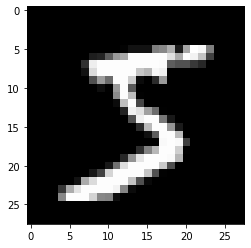

In [4]:
import matplotlib.pyplot as plt

plt.imshow(data[:,:,0], cmap="gray")
plt.show()

In [5]:
from megengine.data import SequentialSampler, RandomSampler

sampler = SequentialSampler(dataset=dataset, batch_size=4)

for i, j in enumerate(sampler):
    print(j)
    if i == 3: break

[0, 1, 2, 3]
[4, 5, 6, 7]
[8, 9, 10, 11]
[12, 13, 14, 15]


In [6]:
from megengine.data import DataLoader
from megengine.data.transform import Compose, Pad, RandomResizedCrop, Normalize, ToMode

dataloader = DataLoader(
    dataset=dataset,
    sampler=SequentialSampler(dataset=dataset, batch_size=500),
    transform=Compose([
        Normalize(mean=33, std=78),
        ToMode("CHW")
    ])
)

In [7]:
import numpy as np

all_data = []

for data, label in dataloader:
    all_data.append(data)

all_data = np.array(all_data)

print(all_data.shape)
print(all_data.mean())
print(all_data.std())

# N C H W

(120, 500, 1, 28, 28)
0.0040823156
1.0072756


### 第二部分 卷积神经网络的构建

In [8]:
from megengine import tensor
import megengine.functional as F
import megengine.module as M

In [9]:
x = np.array([2,-3,4,-5,6], dtype=np.float32)
x = tensor(x)
y = F.relu(x)
print(y)

Tensor([2. 0. 4. 0. 6.])


In [10]:
w = np.array([[1,2,0],[1,3,0]], dtype=np.float32)
b = np.array([[1,2],[-2,-1]], dtype=np.float32)
x = np.array([[1,2,3],[4,5,6]], dtype=np.float32)

In [11]:
print(w)
print("\n")
print(b)
print("\n")
print(x)

[[1. 2. 0.]
 [1. 3. 0.]]


[[ 1.  2.]
 [-2. -1.]]


[[1. 2. 3.]
 [4. 5. 6.]]


In [12]:
y0 = F.linear(tensor(x), weight=tensor(w), bias=tensor(b))
print(y0)

Tensor([[ 6.  9.]
 [12. 18.]])


In [13]:
y1 = np.matmul(x, w.T) + b
print(y1)

[[ 6.  9.]
 [12. 18.]]


In [14]:
model = M.Linear(3, 2)

model.weight.set_value(w)
model.bias.set_value(b)

for name, param in model.named_parameters():
    print(name)
    print(param)
    print("\n")

bias
Tensor([[ 1.  2.]
 [-2. -1.]])


weight
Tensor([[1. 2. 0.]
 [1. 3. 0.]])




In [15]:
y3 = model(tensor(x))
print(y3)

Tensor([[ 6.  9.]
 [12. 18.]])


In [16]:
# N C H W
matrix = np.array([[[[1,12,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]]]], dtype=np.float32)

print(matrix.shape)
print(matrix)

(1, 1, 4, 4)
[[[[ 1. 12.  3.  4.]
   [ 5.  6.  7.  8.]
   [ 9. 10. 11. 12.]
   [13. 14. 15. 16.]]]]


In [17]:
y0 = F.max_pool2d(tensor(matrix), kernel_size=2)
print(y0)

Tensor([[[[12.  8.]
   [14. 16.]]]])


In [18]:
model = M.MaxPool2d(kernel_size=2)
y1 = model(tensor(matrix))
print(y1)

Tensor([[[[12.  8.]
   [14. 16.]]]])


In [19]:
import urllib
url = "https://data.megengine.org.cn/images/cat.jpg"

urllib.request.urlretrieve(url, "cat.jpg")

('cat.jpg', <http.client.HTTPMessage at 0x7f9ace060790>)

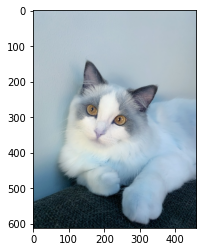

In [20]:
import cv2
image = cv2.imread("cat.jpg")

plt.imshow(image)
plt.show()

In [21]:
print(image.shape)  # H W C
print(image.transpose([2, 0, 1]).shape)  # C H W
print(image.transpose([2, 0, 1])[np.newaxis, :].shape)  # N C H W

image = image.transpose([2, 0, 1])[np.newaxis, :].astype(np.float32)
print(image.dtype)

(612, 459, 3)
(3, 612, 459)
(1, 3, 612, 459)
float32


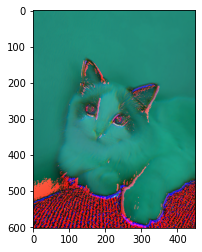

In [22]:
for i in range(1):
    model = M.Conv2d(3, 3, kernel_size=10)
    out = model(tensor(image)).numpy()
    out = out[0].transpose([1,2,0]).astype(np.uint8)
    plt.imshow(out)
    plt.show()

In [23]:
class MnistNet(M.Module):
    def __init__(self):
        self.conv0 = M.Conv2d(1, 20, kernel_size=5)
        self.pool0 = M.MaxPool2d(2)
        self.conv1 = M.Conv2d(20, 20, kernel_size=5)
        self.pool1 = M.MaxPool2d(2)
        self.fc0 = M.Linear(320, 500)
        self.fc1 = M.Linear(500, 10)

    def forward(self, x):
        x = self.conv0(x)
        x = F.relu(x)
        x = self.pool0(x)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = F.flatten(x, 1)
        x = self.fc0(x)
        x = F.relu(x)
        x = self.fc1(x)
        return x

In [24]:
for name, param in model.named_parameters():
    print(name, param.shape)

bias (1, 3, 1, 1)
weight (3, 3, 10, 10)


### 第三部分 梯度下降法与模型训练

In [25]:
import random

# y = k * x + b
K = 4
B = -3
N = 100

data = []
for i in range(N):
    x = random.uniform(-10, 10)
    y = K * x + B + random.uniform(-5, 5)
    data.append((x, y))

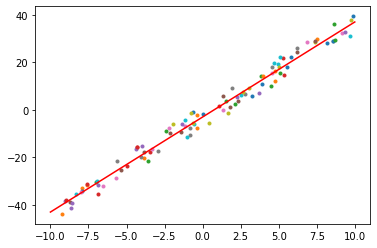

In [26]:
for x, y in data:
    plt.scatter(x, y, marker=".")

x = np.array([-10, 10])
y = K * x + B
plt.plot(x, y, "-r")
plt.show()

epoch = 0, k = 0.000, b = 0.000, loss = 48883.932


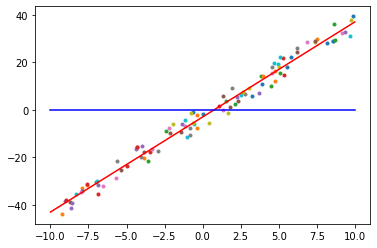

epoch = 1, k = 2.375, b = -0.032, loss = 9305.841


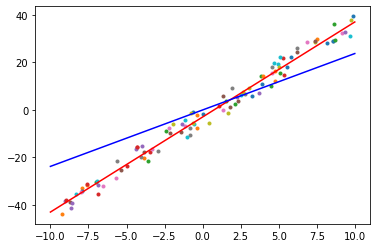

epoch = 2, k = 3.332, b = -0.079, loss = 2843.682


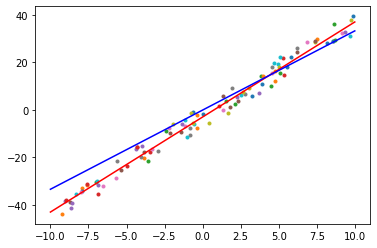

epoch = 3, k = 3.719, b = -0.130, loss = 1767.404


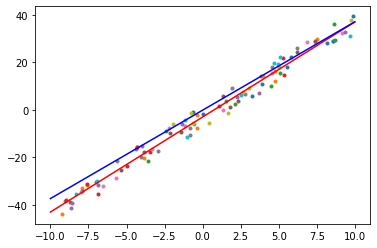

epoch = 4, k = 3.875, b = -0.183, loss = 1567.906


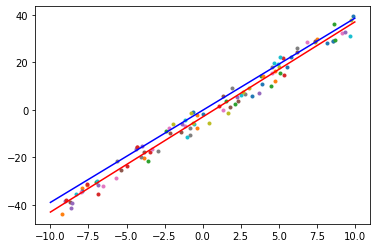

In [27]:
def show(epoch, k, b):
    for x, y in data:
        plt.scatter(x, y, marker=".")

    x = np.array([-10, 10])
    y = K * x + B
    plt.plot(x, y, "-r")

    y = k * x + b
    plt.plot(x, y, "-b")

    plt.show()

k = 0
b = 0
lr = 0.01

for epoch in range(5):
    sum_grad_k = 0
    sum_grad_b = 0
    loss = 0

    for x, y in data:
        pred = k * x + b
        loss += (pred - y) * (pred - y)
        sum_grad_k += 2 * (pred - y) * x
        sum_grad_b += 2 * (pred - y)

    grad_k = sum_grad_k / N
    grad_b = sum_grad_b / N

    print("epoch = {}, k = {:.3f}, b = {:.3f}, loss = {:.3f}".format(epoch, k, b, loss))
    show(epoch, k, b)

    k = k - lr * grad_k
    b = b - lr * grad_b

In [28]:
import megengine as mge

from megengine.data.dataset import MNIST
from megengine.data import RandomSampler, DataLoader
from megengine.data.transform import Compose, Normalize, ToMode

import megengine.functional as F
import megengine.module as M
from megengine.optimizer import SGD
from megengine.jit import trace


class MnistNet(M.Module):
    def __init__(self):
        self.conv0 = M.Conv2d(1, 20, kernel_size=5)
        self.pool0 = M.MaxPool2d(2)
        self.conv1 = M.Conv2d(20, 20, kernel_size=5)
        self.pool1 = M.MaxPool2d(2)
        self.fc0 = M.Linear(320, 500)
        self.fc1 = M.Linear(500, 10)

    def forward(self, x):
        x = self.conv0(x)
        x = F.relu(x)
        x = self.pool0(x)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = F.flatten(x, 1)
        x = self.fc0(x)
        x = F.relu(x)
        x = self.fc1(x)
        return x


def get_dataloader(train=True):
    dataset = MNIST(root="./dataset", train=train, download=True)
    sampler = RandomSampler(dataset=dataset, batch_size=500)
    return DataLoader(
        dataset=dataset,
        sampler=sampler,
        transform=Compose([
            Normalize(mean=33, std=78),
            ToMode("CHW")
        ])
    )


train_data = get_dataloader(train=True)

model = MnistNet()
opt = SGD(model.parameters(), lr=0.01)

@trace
def train(data, label):
    pred = model(data)
    loss = F.cross_entropy_with_softmax(pred, label)
    opt.backward(loss)
    return loss

xs = []
ys = []
for epoch in range(10):
    train_loss = 0
    for data, label in train_data:
        opt.zero_grad()
        loss = train(data, label)
        opt.step()
        train_loss += loss.numpy()[0]
    print("epoch = {}, train_loss = {:.3f}".format(epoch, train_loss))
    xs.append(epoch)
    ys.append(train_loss)

05 02:46:46 process the raw files of train set...
100%|████████████████████████████████| 60000/60000 [00:00<00:00, 1369359.99it/s]


epoch = 0, train_loss = 96.414
epoch = 1, train_loss = 33.946
epoch = 2, train_loss = 25.243
epoch = 3, train_loss = 20.658
epoch = 4, train_loss = 17.935
epoch = 5, train_loss = 15.775
epoch = 6, train_loss = 14.295
epoch = 7, train_loss = 13.242
epoch = 8, train_loss = 12.389
epoch = 9, train_loss = 11.465


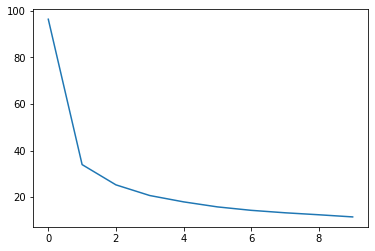

In [29]:
plt.plot(xs, ys)
plt.show()

### 第四部分 模型的保存与加载

In [30]:
import megengine as mge
mge.save(model.state_dict(), "model.pkl")

In [31]:
test_model = MnistNet()
test_model.load_state_dict(mge.load("model.pkl"))

In [32]:
test_data = get_dataloader(train=False)

05 02:47:25 process the raw files of test set...
100%|████████████████████████████████| 10000/10000 [00:00<00:00, 1370418.87it/s]


In [33]:
correct = 0
total = 0

for data, label in test_data:
    pred = F.argmax(test_model(data), 1)
    correct += (pred == label).sum().numpy()[0]
    total += label.shape[0]

print("correct = {}, total = {}, accuracy = {:.2f}%".format(correct, total, correct / total * 100))

correct = 9739, total = 10000, accuracy = 97.39%
